In [1]:
import albumentations as A
import torch
import json
import cv2
import numpy as np
import os
from torch.utils.data import Dataset
import glob
import segmentation_models_pytorch as smp

from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from pywget import wget

In [18]:
from dataloaders import BalloonDatasetSegmentation

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# link = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
# wget.download(link)

In [4]:
# !unzip balloon_dataset.zip

In [5]:
def create_labels(dataset_type='train'):
    f = open(f'balloon\\{dataset_type}\\via_region_data.json')
    json_file = json.load(f)
    for file in json_file:
        path = f'balloon\\{dataset_type}'
        filename = json_file[file]['filename']

        path_to_mask = f"{path}\\masks\\{filename.replace('.jpg', '.png')}"

        if os.path.exists(path_to_mask):
            continue
        else:                
            img = cv2.imread(f'{path}\\{filename}')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            regions = json_file[file]['regions']
            label = np.zeros_like(img)

            for n in regions:
                mask = np.zeros((img.shape[0], img.shape[1]))
                x_coords = regions[n]['shape_attributes']['all_points_x']
                y_coords = regions[n]['shape_attributes']['all_points_y']
                coords_of_polygon = np.dstack((x_coords, y_coords))
                cv2.fillConvexPoly(mask, coords_of_polygon, 1)
                mask = mask.astype(bool)
                label[mask] = 1
            cv2.imwrite(path_to_mask, label)

In [6]:
create_labels('train')
create_labels('val')

In [7]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [9]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'


# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
def minimal_augmentation():
    transform = [
        A.Resize(height=512, width=512, p=1)]
    return A.Compose(transform)


def get_training_augmentation():
    train_transform = [
        A.Resize(height=512, width=512, p=1),
        
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),

        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

In [12]:
balloon_dataset = BalloonDatasetSegmentation('balloon\\train', 
                                             classes=['balloon'], 
                                             preprocessing=get_preprocessing(preprocessing_fn),
                                             augmentation=get_training_augmentation(),)

valid_dataset = BalloonDatasetSegmentation('balloon\\val',
                                           classes=['balloon'],
                                           preprocessing=get_preprocessing(preprocessing_fn),
                                           augmentation=minimal_augmentation(),)

train_size = int(0.8 * len(balloon_dataset))
test_size = len(balloon_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(balloon_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

C:\Users\yaroslav\anaconda3\envs\ml-env\lib\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\yaroslav\anaconda3\envs\ml-env\lib\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


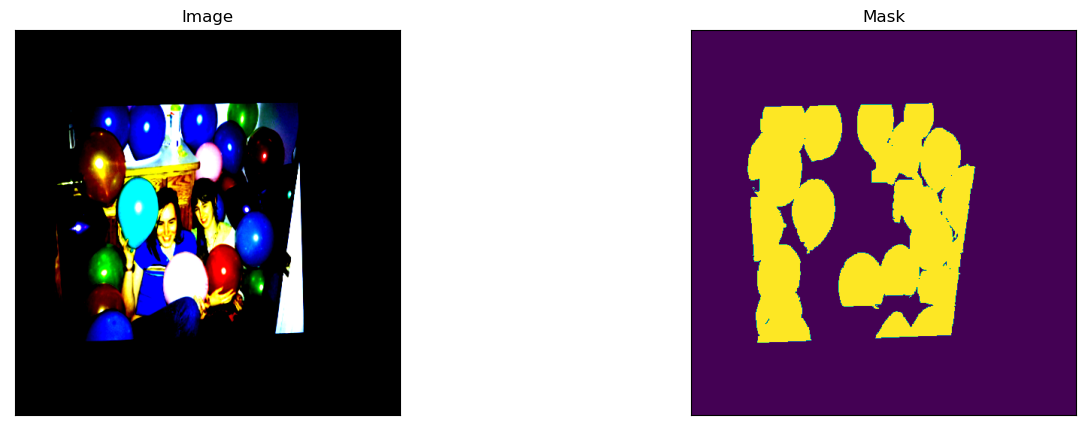

In [13]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

image, mask = train_dataset[2]
visualize(image=image.transpose((1, 2, 0)), 
          mask=mask.transpose((1, 2, 0))*255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


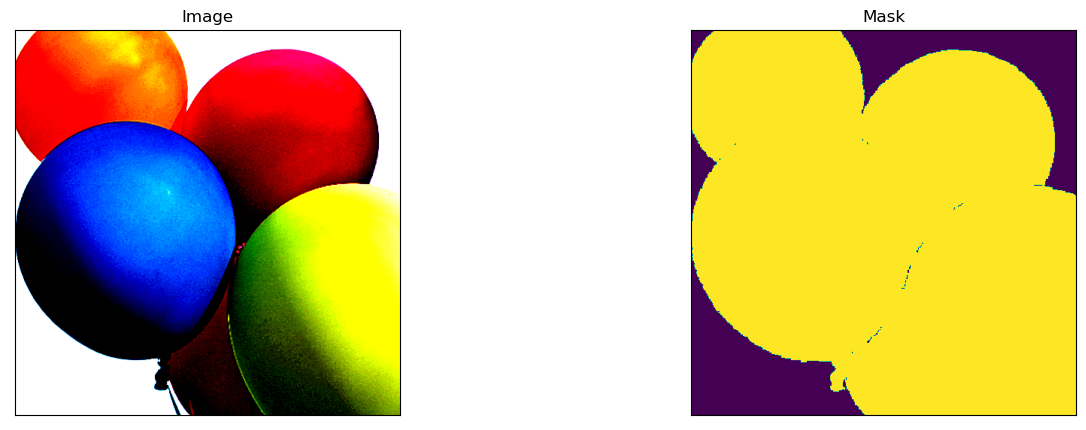

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


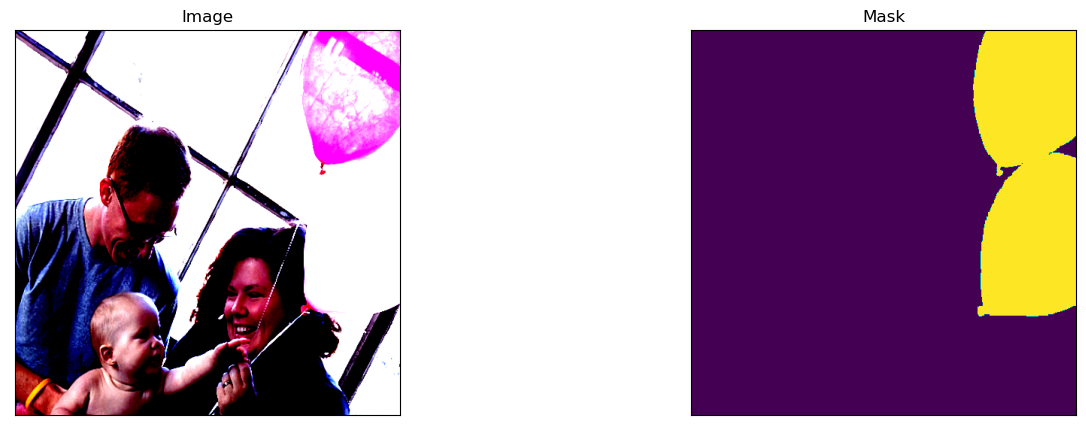

In [14]:
augmented_dataset = BalloonDatasetSegmentation('balloon\\train', 
                                             classes=['balloon'], 
                                             preprocessing=get_preprocessing(preprocessing_fn),
                                             augmentation=get_training_augmentation())

# same image with different random transforms
for i in range(2):
    image, mask = augmented_dataset[i]
    visualize(image=image.transpose(1, 2, 0), 
              mask=mask.transpose(1, 2, 0))

In [15]:
metrics = [
    smp.utils.metrics.IoU(eps=1., activation = None),
]
loss = smp.utils.losses.DiceLoss()
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [16]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=False,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=False,
)


Epoch: 0
Train IoU:0.25
Validation IoU:0.25
Model saved!

Epoch: 10
Train IoU:0.79
Validation IoU:0.83
Model saved!


KeyboardInterrupt: 

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
test_dataloader = DataLoader(test_dataset)
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device='cuda',
    verbose=True
)

logs = test_epoch.run(test_dataloader)

In [ ]:
for i in range(2):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    
   
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    visualize(
        image=image.transpose(1, 2, 0), 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )